In [18]:
import numpy as np
import matplotlib.pyplot as plt

### Grid 

In [19]:
class Grid:
    def __init__(self, xmin: float, xmax: float, nx: int, n_ghost: int = 1):
        self.xmin = xmin
        self.xmax = xmax
        self.nx = nx
        self.tot_nx = nx + 2 * n_ghost
        self.dx = (xmax - xmin) / (nx - 1)
        self.x = np.linspace(xmin, xmax, nx)
        self.x = np.insert(self.x, 0, self.x[0])
        self.x = np.insert(self.x, self.x.shape[0], self.x[-1])

### Primitive variables to conserved variables

In [20]:
def prim_to_cons_vars(pv: np.ndarray) -> np.ndarray:
    cv = np.zeros(pv.shape)
    cv[:, 0] = pv[:, 0]
    cv[:, 1] = pv[:, 0] * pv[:, 1]
    cv[:, 2] = pv[:, 0] * (pv[:, 2] / (pv[:, 0] * (1.4 - 1)) + 0.5 * pv[:, 1] ** 2)

    return cv

### Conserved variables to primitive variables

In [21]:
def cons_to_prim_vars(cv: np.ndarray) -> np.ndarray:
    pv = np.zeros(cv.shape)
    pv[:, 0] = cv[:, 0]
    pv[:, 1] = cv[:, 1] / cv[:, 0]
    pv[:, 2] = (cv[:, 2] / cv[:, 0] - 0.5 * pv[:, 1] ** 2) * cv[:, 0] * (1.4 - 1)

    return pv

### Conserved variables to flux

In [22]:
def conv_vars_to_flux(cv: np.ndarray) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    f = np.zeros(cv.shape)
    f[:, 0] = cv[:, 1]
    f[:, 1] = pv[:, 2] + cv[:, 1] * pv[:, 1]
    f[:, 2] = pv[:, 2] * pv[:, 1] + cv[:, 2] * pv[:, 1]

    return f

### To compute time step

In [23]:
def time_step(cv: np.ndarray, dx: float, cfl: float = 0.2) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    a = np.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val = np.abs(pv[:, 1] + a)
    dt = cfl * dx / eig_val
    
    return np.min(dt)

### To compute Rusanov (LLF) flux

In [24]:
def llf_flux(cv: np.ndarray) -> np.ndarray:
    f = conv_vars_to_flux(cv)
    pv = cons_to_prim_vars(cv)
    a = np.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val_l = np.abs(pv[1:-1, 1]) + a[1:-1]
    eig_val_r = np.abs(pv[2:, 1]) + a[2:]
    max_eig_val = np.maximum(eig_val_l, eig_val_r)
    max_eig_val = max_eig_val.reshape(max_eig_val.size, 1)
    f_iph = 0.5 * (f[1:-1, :] + f[2:, :]) - 0.5 * max_eig_val * (cv[2:, :] - cv[1:-1, :])

    eig_val_l = np.abs(pv[:-2, 1]) + a[:-2]
    eig_val_r = np.abs(pv[1:-1, 1]) + a[1:-1]
    max_eig_val = np.maximum(eig_val_l, eig_val_r)
    max_eig_val = max_eig_val.reshape(max_eig_val.size, 1)
    f_imh = 0.5 * (f[1:-1, :] + f[:-2, :]) - 0.5 * max_eig_val * (cv[1:-1, :] - cv[:-2, :])

    return f_iph - f_imh

### Initial and boundary conditions

In [25]:
def initialize(pv_l: np.ndarray, pv_r: np.ndarray, x: np.ndarray, pv: np.ndarray, xloc):
    pv[np.argwhere(x <= xloc), :] = pv_l
    pv[np.argwhere(x > xloc), :] = pv_r

def bc(cv: np.ndarray) -> np.ndarray:
    pv = cons_to_prim_vars(cv)
    pv = np.insert(pv, 0, pv[0], axis=0)
    pv = np.insert(pv, pv.shape[0], pv[-1], axis=0)

    con_var = prim_to_cons_vars(pv)

    return con_var

### Simulation parameters

In [26]:
prim_var_l = np.array([1.0, 0.75, 1.0])
prim_var_r = np.array([0.125, 0.0, 0.1])

cfl_num = 0.9
grid = Grid(0, 1, 3001)
x_grid = grid.x
x_loc = 0.3
prim_var = np.zeros((x_grid.size, 3))
initialize(prim_var_l, prim_var_r, x_grid, prim_var, x_loc)

cons_var = prim_to_cons_vars(prim_var)
flux = conv_vars_to_flux(cons_var)
prim_var = cons_to_prim_vars(cons_var)

### Run the simulation

In [27]:
%%time
time = 0
while time <= 0.2:
    t_dt = time_step(cons_var, grid.dx, cfl_num)
    flux = llf_flux(cons_var)
    cv_new = cons_var[1:-1, :] - (t_dt / grid.dx) * flux
    cons_var = bc(cv_new)
    time += t_dt
    print(time)

0.00015518183520713666
0.00029434910380187195
0.0004255426811289981
0.0005516756586516386
0.0006752024164733894
0.0007978788992360031
0.0009192876401779223
0.0010385810731140534
0.0011569873472953116
0.0012744325568743724
0.0013907944221426024
0.0015067131531251218
0.0016224215788070775
0.0017373239945679682
0.0018518511443499004
0.001966217566134784
0.0020799548286243967
0.002193379497001119
0.0023068398198851084
0.0024197538009600003
0.002532376154897684
0.0026450114796718353
0.002757270031811488
0.002869254012934483
0.0029812169132624805
0.0030929668109667217
0.0032044552194862956
0.0033158939457781328
0.0034272308126091448
0.0035383230579367963
0.003649344479831403
0.0037603451723249403
0.0038711209910018665
0.003981811455655171
0.004092533064671031
0.004203052079775161
0.004313478243432308
0.004423966837689589
0.004534275848878631
0.0046444904909464305
0.00475473603413952
0.004864871303834983
0.004974915491398692
0.0050849673858224895
0.005194957566534878
0.005304863138523666
0.00

0.04703628566213072
0.04714550363028692
0.04725472157299072
0.04736393949525735
0.04747315739317121
0.04758237526992054
0.04769159312341482
0.047800810955018515
0.0479100287644627
0.048019246551291715
0.04812846431705416
0.04823768205947847
0.04834689978192618
0.04845611748031452
0.04856533515932908
0.04867455281404877
0.04878377044872938
0.04889298806014621
0.04900220565086018
0.04911142321933822
0.049220640766451246
0.04932985829235266
0.049439075796228665
0.049548293279913586
0.04965751074091454
0.04976672818274096
0.049875945601226775
0.049985163000784524
0.05009438037711293
0.05020359773390668
0.050312815068433124
0.050422032382820045
0.05053124967589754
0.050640466948232474
0.05074968420021155
0.050858901430846926
0.050968118642075524
0.051077335831361245
0.05118655300218464
0.05129577015046802
0.05140498728035732
0.05151420438798301
0.05162342147666221
0.05173263854397211
0.05184185559178497
0.05195107261911818
0.0520602896264057
0.05216950661409848
0.05227872358119887
0.0523879

0.09760254820170425
0.09771176015155095
0.09782097209399758
0.09793018402941993
0.09803939595740635
0.09814860787846473
0.09825781979205167
0.09836703169878923
0.09847624359803696
0.09858545549040117
0.09869466737536954
0.09880387925342056
0.09891309112416898
0.09902230298796653
0.09913151484455397
0.09924072669415737
0.09934993853664238
0.09945915037211048
0.0995683622005512
0.09967757402194245
0.09978678583639658
0.09989599764376901
0.10000520944429385
0.10011442123770507
0.10022363302435752
0.10033284480386476
0.1004420565767013
0.10055126834236132
0.1006604801014179
0.10076969185328712
0.10087890359852275
0.10098811533665715
0.10109732706812811
0.1012065387925833
0.10131575051034548
0.10142496222117667
0.10153417392528556
0.10164338562254757
0.1017525973130583
0.10186180899680557
0.10197102067377284
0.10208023234405941
0.10218944400753759
0.10229865566441716
0.1024078673144602
0.10251707895798608
0.10262629059464756
0.1027355022248727
0.10284471384820586
0.10295392546517453
0.10306

0.15013284671277086
0.15024205624961928
0.15035126578298919
0.15046047531285534
0.15056968483924163
0.15067889436214374
0.15078810388156466
0.1508973133975209
0.1510065229099947
0.15111573241902315
0.1512249419245679
0.15133415142668658
0.1514433609253203
0.1515525704205471
0.15166177991228777
0.15177098940062855
0.1518801988854941
0.15198940836695848
0.15209861784496664
0.15220782731957253
0.15231703679074107
0.15242624625850618
0.15253545572285276
0.1526446651837948
0.15275387464133697
0.15286308409547353
0.15297229354622882
0.15308150299357745
0.1531907124375633
0.15329992187814145
0.15340913131537517
0.15351834074920023
0.153627550179696
0.15373675960678526
0.15384596903054423
0.15395517845091494
0.1540643878679544
0.15417359728162372
0.15428280669196084
0.15439201609894587
0.1545012255025978
0.15461043490291557
0.15471964429989932
0.15482885369356678
0.15493806308389935
0.15504727247093333
0.1551564818546316
0.15526569123504896
0.1553749006121298
0.15548410998594725
0.155593319356

0.19720188011240247
0.1973110884513671
0.19742029678811365
0.19752950512263245
0.19763871345493472
0.19774792178501674
0.19785713011288306
0.19796633843853734
0.19807554676197675
0.1981847550832123
0.1982939634022338
0.19840317171905228
0.19851238003366484
0.1986215883460752
0.1987307966562878
0.19884000496429902
0.19894921327011975
0.19905842157374076
0.19916762987517211
0.1992768381744118
0.19938604647146266
0.1994952547663299
0.19960446305900914
0.19971367134951107
0.19982287963782752
0.1999320879239675
0.20004129620792999
CPU times: user 1.61 s, sys: 100 ms, total: 1.71 s
Wall time: 1.65 s


### Plot results

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

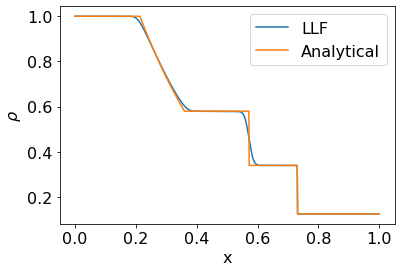

In [28]:
prim_var = cons_to_prim_vars(cons_var)
analytical = np.loadtxt('/mnt/external_data/maruthi/my_codes/compressible_euler_1d/output/shock_tube.dat')
plt.plot(x_grid, prim_var[:, 0], label='LLF')
plt.plot(analytical[:, 0], analytical[:, 1], label='Analytical')
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$\rho $', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [12]:
# !numba -s